Reference: https://www.tensorflow.org/tutorials/text/image_captioning

In [ ]:
# Download kaggle pip package so we can download the
# Flickr8K dataset via Kaggle API.
!pip -q install kaggle

In [ ]:
# IMPORTS

import tensorflow as tf
import os
import json
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import collections
import random
import requests
import time
from PIL import Image
from tqdm.auto import tqdm

In [ ]:
COLAB = os.path.exists('/content/')

if COLAB:
    BASE_DIR = '/content'
else:
    BASE_DIR = '.'

## **Download Flickr8K Dataset**

You must input your Kaggle credentials in the code cell below to download the Flickr8K dataset. If you are unsure how to obtain your credentials, follow these steps:

1. Go to <a href='https://www.kaggle.com/'>kaggle.com</a>
2. Sign in/Log in first, then click on your profile photo in the upper right corner.
3. Go to 'Your Profile'
4. Go to 'Account'
5. Scroll down until you find the 'API' section, then click on 'Create New API Token.'
6. The file kaggle.json will be downloaded. Open it and enter your username and key below.

You are good to go!

In [ ]:
# Download Flickr8K dataset

if not os.path.exists(f'{BASE_DIR}/data/'):
    
    # Enter your kaggle credentials
    api_token = {"username": "<-- Your username here -->",
                 "key": "<-- Your Key Here -->"}

    with open(f'{BASE_DIR}/kaggle.json', 'w') as file:
        json.dump(api_token, file)

    os.environ["KAGGLE_CONFIG_DIR"] = BASE_DIR
    os.system('kaggle datasets download -d adityajn105/flickr8k')
    os.makedirs(f'{BASE_DIR}/data/', exist_ok=True)
    os.system(f'mv {BASE_DIR}/flickr8k.zip {BASE_DIR}/data/flickr8k.zip')
    os.system(f'unzip -q {BASE_DIR}/data/flickr8k.zip -d {BASE_DIR}/data/')
    os.remove(f'{BASE_DIR}/data/flickr8k.zip')

Now, open the files and expand the `data` folder, it will have a `Image` folder containing all 8000 images as well as captions.txt, which contains five captions for each image.

In [ ]:
# load the captions.txt with pandas
captions = pd.read_csv(f'{BASE_DIR}/data/captions.txt')
captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
print('Dataset shape:', captions.shape)

Dataset shape: (40455, 2)


In [ ]:
# Because the image column just contains the image name, let's enter
# the complete path of the image so we can easily access it.
captions['image'] = captions['image'].apply(
    lambda x: f'{BASE_DIR}/data/Images/{x}')

## **Text Preprocessing**

In [ ]:
def preprocess(text):
    '''
    This function will pre-process text
    '''
    
    # making it lowercase
    text = text.lower()

    # remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # remove extra spaces
    text = re.sub('\s+', ' ', text)
    text = text.strip()

    # add [start] and [end] special token
    text = '[start] ' + text + ' [end]'

    return text

In [ ]:
# apply the text pre-processing on caption column
captions['caption'] = captions['caption'].apply(preprocess)
captions.head()

[start] a small child in a pink hoodie ascending tall stairs outdoors [end]



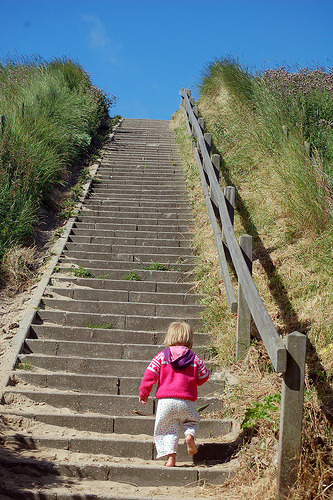

In [ ]:
# display a random image with caption
random_row = captions.sample(1).iloc[0]

# print the caption of random row
print(random_row.caption + '\n')

# display the image of random row with PIL
im = Image.open(random_row.image)
im

# Every time you run this cell, you will get a new image.

## **Cache Feature Vectors**

Instead of directly including Inception V3 in the training loop, we will store all feature vectors (that inception v3 generates) in the `feature_vectors` directory and access it from there to speed up training.

In [ ]:
# Load the Inception V3 model
inception_v3 = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet'
)
inception_v3.trainable = False

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
def load_image(path):
    '''
    pre-process image
    '''

    # load image from disk
    img = tf.io.read_file(path)

    # make it a tensor
    img = tf.io.decode_jpeg(img, channels=3)

    # resize it to 299 X 299
    img = tf.keras.layers.Resizing(299, 299)(img)

    # apply inception v3 preprocessing
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    return img, path

In [ ]:
# unique image paths from the dataset (it's 8000, remember?)
unique_img_paths = sorted(list(captions['image'].unique()))

# we will batch image paths using TensorFlow Dataset
image_dataset = tf.data.Dataset.from_tensor_slices(unique_img_paths)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

In [ ]:
# Let's iterate through all the image paths, load it with our
# `load_img()` function and save it in the feature_vectors 
# directory

fv_path = f'{BASE_DIR}/feature_vectors/'
os.makedirs(fv_path, exist_ok=True)

for img, paths in tqdm(image_dataset, total=len(image_dataset)):
    feature_vector = inception_v3(img)
    # the feature_vector is of shape
    # (batch_size, 8, 8, 2048)
    
    feature_vector = tf.reshape(
        feature_vector,
        (feature_vector.shape[0], -1, feature_vector.shape[3])
    )
    # now it is of shape (batch_size, 8*8, 2048) = 
    # (batch_size, 64, 2048)
    
    for fv, path in zip(feature_vector, paths):
        path = path.numpy().decode("utf-8")
        path = fv_path + path.split('/')[-1]
        np.save(path, fv.numpy())

  0%|          | 0/506 [00:00<?, ?it/s]

All of the feature vectors are stored. As a result, instead of using image paths, we will directly use these feature vectors path for training. There is no longer any requirement to incorporate inception v3 in the training loop.

In [ ]:
# Let's add the feature_vector column, which will 
# include the path to each image's feature vector.

captions['feature_vector'] = captions['image'].apply(
    lambda x: x.replace('data/Images', 'feature_vectors') + '.npy'
)

captions = captions[['image', 'feature_vector', 'caption']]
captions.head()

,image,feature_vector,caption
0,/content/data/Images/1000268201_693b08cb0e.jpg,/content/feature_vectors/1000268201_693b08cb0e...,[start] a child in a pink dress is climbing up...
1,/content/data/Images/1000268201_693b08cb0e.jpg,/content/feature_vectors/1000268201_693b08cb0e...,[start] a girl going into a wooden building [end]
2,/content/data/Images/1000268201_693b08cb0e.jpg,/content/feature_vectors/1000268201_693b08cb0e...,[start] a little girl climbing into a wooden p...
3,/content/data/Images/1000268201_693b08cb0e.jpg,/content/feature_vectors/1000268201_693b08cb0e...,[start] a little girl climbing the stairs to h...
4,/content/data/Images/1000268201_693b08cb0e.jpg,/content/feature_vectors/1000268201_693b08cb0e...,[start] a little girl in a pink dress going in...


## **Text Vectorization**

In [ ]:
# Text vectorizer for captions

max_length = 40          # maximum number of words in sentence
vocabulary_size = 5000   # maximum vocabulary size

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None,
    output_sequence_length=max_length)

# the adapt function below will build the vocabulary
tokenizer.adapt(captions['caption'])

In [ ]:
# Let's test the `tokenizer`
tokenizer(['a dog running'])

<tf.Tensor: shape=(1, 40), dtype=int64, numpy=
array([[ 2, 10, 33,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])>

In [ ]:
import pickle
pickle.dump(tokenizer.get_vocabulary(), open('vocab_encdec.file', 'wb'))

As you can see, it has assigned each word to an unique integer, and the rest of the zeros are padding to ensure that each sentence is of equal length.

In [ ]:
# creating word2idx and idx2word so we can easily covert word to index and vice versa

word2idx = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())

idx2word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

## **Train-Validation Split**

Now we'll do the train validation split, but because we have many rows with the same image, randomly shuffling the data and then taking a fraction of it won't work as training and validation set will end up having similar images. To avoid this leakage, we must take a long route, as follows:

In [ ]:
# Train-Validation split
# fv means feature vectors

fv_to_cap_vector = collections.defaultdict(list)
for fv, cap in zip(captions['feature_vector'], captions['caption']):
    fv_to_cap_vector[fv].append(cap)

fv_keys = list(fv_to_cap_vector.keys())
random.shuffle(fv_keys)

slice_index = int(len(fv_keys)*0.8)
fv_name_train_keys, fv_name_val_keys = fv_keys[:slice_index], fv_keys[slice_index:]

train_feature_vectors = []
train_captions = []
for fvt in fv_name_train_keys:
    capt_len = len(fv_to_cap_vector[fvt])
    train_feature_vectors.extend([fvt] * capt_len)
    train_captions.extend(fv_to_cap_vector[fvt])

val_feature_vectors = []
val_captions = []
for fvv in fv_name_val_keys:
    capv_len = len(fv_to_cap_vector[fvv])
    val_feature_vectors.extend([fvv] * capv_len)
    val_captions.extend(fv_to_cap_vector[fvv])

In [ ]:
print(len(train_feature_vectors), len(val_feature_vectors))

32360 8095


In [ ]:
# Let's review how are train images and captions look like,
print(train_feature_vectors[0])
print()
print(train_captions[0])

/content/feature_vectors/3413571342_b9855795e2.jpg.npy

[start] a man in colorful shorts is surfing under a wave [end]


## **Putting image and captions together**

In [ ]:
# Hyper-Parameters

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = tokenizer.vocabulary_size()

In [ ]:
def load_data(fv_path, caption):
    '''
    This image will take feature vector path and caption string and return
    the loaded feature vector array and apply the `tokenizer`
    to the caption.
    '''

    # Step 1: Load feature vector
    feature_vector = np.load(fv_path.decode('utf-8'))

    # Step 2: Tokenize caption
    tokenized_caption = tokenizer(caption)

    return feature_vector, tokenized_caption

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_feature_vectors, train_captions))

# apply the `load_data()` function
train_dataset = train_dataset.map(
    lambda item1, item2: tf.numpy_function(
        load_data, [item1, item2], [tf.float32, tf.int64]),
        num_parallel_calls=tf.data.AUTOTUNE
    )

# shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


# Do the same for validation set
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_feature_vectors, val_captions))

val_dataset = val_dataset.map(
    lambda item1, item2: tf.numpy_function(
        load_data, [item1, item2], [tf.float32, tf.int64]),
        num_parallel_calls=tf.data.AUTOTUNE
    )

val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
img, cap = next(iter(train_dataset))
print('Image shape:', img.shape)
print('Caption shape:', cap.shape)

Image shape: (64, 64, 2048)
Caption shape: (64, 40)


In [ ]:
# The Encoder

class CNNEncoder(tf.keras.layers.Layer):

    def __init__(self, embedding_dim):
        super(CNNEncoder, self).__init__()
        # since we have already saved all the feature vectors, we can
        # pass them via a fully connected layer. This will transform it
        # into the shape (batch_size, 64, embedding_dim)
        # if you will not include this layer there won't be any learning at 
        # the encoder part at all.
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
# The Attention mechanisn

class BahdanauAttention(tf.keras.layers.Layer):

    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)


    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) +
                                  self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
# The Decoder

class RNNDecoder(tf.keras.layers.Layer):

    def __init__(self, embedding_dim, units, vocab_size):
        super(RNNDecoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.attention = BahdanauAttention(units)
        self.gru = tf.keras.layers.GRU(
            self.units,
            return_sequences=True,
            return_state=True,
        )
        self.fc1 = tf.keras.layers.Dense(units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

    def call(self, x, features, hidden):
        # we will calculate attention between image's feature vector and 
        # text's hidden state.
        context_vector, attention_weights = self.attention(features, hidden)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)
        return x, state, attention_weights


    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNNEncoder(embedding_dim)
decoder = RNNDecoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()

def loss_fn(y_true, y_pred):
    # calculate loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)


    # we will mask out the padding tokens
    mask = y_true != 0
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    return tf.reduce_mean(loss)

In [ ]:
loss_history = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
    '''
    a forward and backward pass of a single batch
    '''
    # initial loss is zero
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    # initial decoder input
    dec_input = tf.expand_dims(target[:, 0], 1)

    with tf.GradientTape() as tape:
        # getting features from encoder
        features = encoder(img_tensor)

        # we will generate the next words with this for loop
        for i in range(1, target.shape[1]):
            # pass features and captions through decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            # calculate loss between the predicted next word and the actual next word
            loss += loss_fn(target[:, i], predictions)

            # teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    # taking the mean of total_loss
    total_loss = (loss / int(target.shape[1]))

    # backward pass
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [ ]:
EPOCHS = 10

# The training loop

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    with tqdm(total=len(train_dataset)) as pbar:

        for (batch, (img_tensor, target)) in enumerate(train_dataset):
            # run the `train_step()` for every batch
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

            # we will pring loss value after every 100 batch
            if batch % 100 == 0:
                average_batch_loss = batch_loss.numpy()/int(target.shape[1])
                print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
            
            pbar.update(1)
    
    loss_history.append(total_loss/len(train_dataset))

    print(f'Epoch {epoch+1} Loss {total_loss/len(train_dataset):.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

NameError: ignored

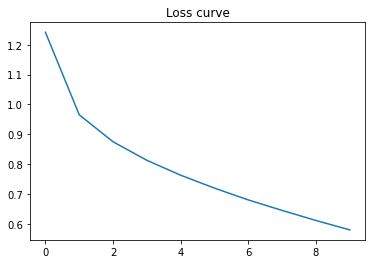

In [ ]:
plt.plot(loss_history)
plt.title('Loss curve')
plt.show()

In [ ]:
def evaluate(image):
    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = inception_v3(temp_input)

    img_tensor_val = tf.reshape(
        img_tensor_val, 
        (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])
    )

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word2idx('[start]')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(idx2word(predicted_id).numpy())

        if predicted_word == '[end]':
            return result
            
        result.append(predicted_word)

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

Real Caption: [start] the gray dog sits quietly dressed in a blue track jacket [end]

Prediction Caption: a kid in a blue shirt holds a blue outfit return to catch a green collar looks at someone wearing a blue shirt dog



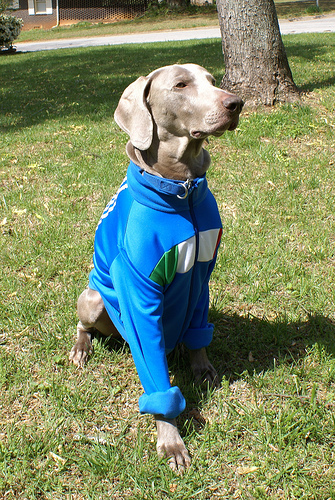

In [ ]:
random_row = captions.sample(1).iloc[0]

image = random_row['image']
caption = random_row['caption'] 

result = evaluate(image)

print('Real Caption:', caption)
print('\nPrediction Caption:', ' '.join(result))
print()
Image.open(image)